In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [40]:
df = pd.read_csv("url_enriched_data.csv")
print(df.shape)

(932078, 7)


In [41]:
print(df.isnull().values.any())

False


In [42]:
df['label'].value_counts()

label
1    587257
0    344821
Name: count, dtype: int64

In [43]:
frauds = df[df.label == 1]
print(frauds.shape)

(587257, 7)


In [44]:
df.corr()['label']

len                -0.380088
spec_chars         -0.300798
domain                   NaN
depth              -0.610174
numericals_count   -0.119344
word_count         -0.109963
label               1.000000
Name: label, dtype: float64

In [45]:
data = df.drop(["domain"], axis=1)
print(data.shape)

(932078, 6)


In [46]:
X = data.drop(columns = 'label').values
Y = data['label']

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [65]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(745662, 5)
(186416, 5)
(745662,)
(186416,)


In [50]:
from keras import regularizers
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model

In [51]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

encoder = Dense(input_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(input_dim), activation="relu")(encoder)
encoder = Dense(int(input_dim - 2), activation="relu")(encoder)
code = Dense(int(input_dim - 4), activation="tanh")(encoder)
decoder = Dense(int(input_dim - 2), activation="tanh")(code)

decoder = Dense(int(input_dim), activation="tanh")(encoder)
decoder = Dense(input_dim, activation="relu")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [57]:
nb_epoch = 50
batch_size = 100

autoencoder.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

In [58]:
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)

In [59]:
tensorboard = TensorBoard(log_dir="./logs", histogram_freq=0, write_graph=True, write_images=True)

In [60]:
history = autoencoder.fit(X_train,X_train,epochs=nb_epoch,batch_size=batch_size,
        shuffle=True,validation_data=(X_test, X_test),verbose=1,
        callbacks=[checkpointer, tensorboard],).history

Epoch 1/50
7457/7457 [==============================] - 30s 3ms/step - loss: 122.5201 - accuracy: 1.0000 - val_loss: 80.1382 - val_accuracy: 1.0000
Epoch 2/50
  71/7457 [..............................] - ETA: 16s - loss: 169.5503 - accuracy: 1.0000

c:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7457/7457 [==============================] - 20s 3ms/step - loss: 68.1820 - accuracy: 1.0000 - val_loss: 47.1437 - val_accuracy: 1.0000
Epoch 3/50
7457/7457 [==============================] - 19s 3ms/step - loss: 47.1018 - accuracy: 1.0000 - val_loss: 36.3594 - val_accuracy: 1.0000
Epoch 4/50
7457/7457 [==============================] - 19s 3ms/step - loss: 39.0359 - accuracy: 1.0000 - val_loss: 30.5528 - val_accuracy: 1.0000
Epoch 5/50
7457/7457 [==============================] - 19s 3ms/step - loss: 34.0230 - accuracy: 1.0000 - val_loss: 26.6978 - val_accuracy: 1.0000
Epoch 6/50
7457/7457 [==============================] - 19s 3ms/step - loss: 30.5131 - accuracy: 1.0000 - val_loss: 23.9652 - val_accuracy: 1.0000
Epoch 7/50
7457/7457 [==============================] - 19s 3ms/step - loss: 27.8561 - accuracy: 1.0000 - val_loss: 22.2232 - val_accuracy: 1.0000
Epoch 8/50
7457/7457 [==============================] - 19s 3ms/step - loss: 25.7475 - accuracy: 1.0000 - val_loss: 20.0972 - val

In [61]:
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix

In [62]:
autoencoder = load_model("model.h5")
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({"reconstruction_error": mse, "true_class": Y_test})
print("Mean Squared Error is : ", mse)

5826/5826 [==============================] - 6s 943us/step
Mean Squared Error is :  [0.4538501  3.9473109  2.17170653 ... 0.50160956 0.29350766 0.08503585]


In [63]:
threshold = 0.0
f1 = 0
recall = 0
accuracy = 0
best_f1 = 0
best_threshold = 0.0

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
precision = 1.0 * tp / (tp + fp)
recall = 1.0 * tp / (tp + fn)
f1 = (2 * recall * precision) / (recall + precision)        
print(f"TP:{tp}")
print(f"FP:{fp}")
print(f"TN:{tn}")
print(f"FN:{fn}")
accuracy = 1.0 * (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy:{accuracy}")
print(f"Precision:{precision}")
print(f"Recall:{recall}")
print(f"F1:{f1}")

TP:117718
FP:68698
TN:0
FN:0
Accuracy:0.6314801304609047
Precision:0.6314801304609047
Recall:1.0
F1:0.7741193026757943


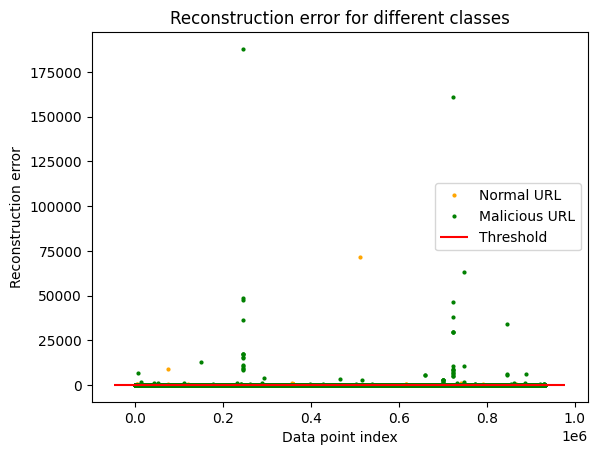

In [64]:
groups = error_df.groupby("true_class")
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index,group.reconstruction_error,
            marker="o",ms=2, linestyle="",
            label="Malicious URL" if name == 1 else "Normal URL",
            color="green" if name == 1 else "orange",)
ax.hlines(best_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="red", zorder=100, label="Threshold")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()


In [66]:
dataset = pd.read_csv("url_enriched_data.csv")
dataset

,len,spec_chars,domain,depth,numericals_count,word_count,label
0,17,1,0,0,0,1,1
1,30,2,0,0,0,1,1
2,35,2,0,0,0,1,1
3,22,1,0,0,0,1,1
4,23,2,0,0,0,1,1
...,...,...,...,...,...,...,...
932073,26,2,0,3,0,0,1
932074,27,2,0,4,0,0,1
932075,27,2,0,4,0,0,1
932076,18,1,0,0,0,0,1
